In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio

# Notebook to generate head obs from DEC wells

### Read in and merge DEC well data. Souce data from:
* NYDEC downloadable well database: https://www.dec.ny.gov/energy/1603.html
* NYDEC water well database, via NYS GIS Clearinghouse: https://gis.ny.gov/gisdata/inventories/details.cfm?DSID=1203



In [2]:
dec_wells = gp.read_file('../source_data/Shapefiles/Wells/NYDEC_All_wells_clipped.shp')
water_wells = gp.read_file('../source_data/Shapefiles/Wells/NYDEC_water_wells_clipped.shp')

In [3]:
#  read in basin boundary for plotting
bound = gp.read_file('../source_data/Shapefiles/Extents/Model_Extent_HUC12.shp')
bound = bound.to_crs(epsg=5070)

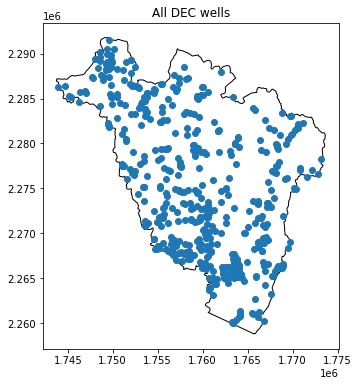

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
bound.plot(ax=ax, edgecolor='k', facecolor='none')
dec_wells.plot(ax=ax)
plt.title('All DEC wells')
plt.show()

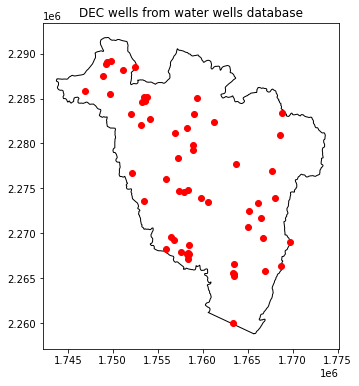

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
bound.plot(ax=ax, edgecolor='k', facecolor='none')
water_wells.plot(ax=ax, c='red')
plt.title('DEC wells from water wells database')
plt.show()

## Combine the the two DEC well dataframes and work up into an obs file

In [6]:
dec_wells['group'] = 'dec_all'
dec_wells['obsnme'] = dec_wells['WellNO'] #  make common obsname

In [7]:
water_wells['group'] = 'dec_water_wells'
water_wells['obsnme'] = water_wells['DEC_Well_N'] #  make common obsname

In [8]:
dec_wells_all = dec_wells.append(water_wells, ignore_index=True)
dec_wells_all

,County,Town,WellNO,Latitude,Latitude_X,Latitude_Y,Longitude,Longitude_,Longitude1,llmethod,...,SCR1_Lnth,YT_AvgDisc,Case2_Ln_1,DDLAT,DDLONG,geometry,group,obsnme,DEC_Well_N,Rock_Depth
0,SULLIVAN,Thompson,SV700,41 37 50.5,37.841667,41.0,74 35 12.9,35.215000,74.0,GPS,...,0.0,15.0,0.0,41.630694,-74.586917,POINT (1755937.644 2268259.383),dec_all,SV700,NaN,NaN
1,SULLIVAN,Mamakating,SV731,41 35 57.0,35.950000,41.0,74 31 05.5,31.091667,74.0,None,...,0.0,0.0,0.0,41.599167,-74.518194,POINT (1762267.695 2266092.657),dec_all,SV731,NaN,NaN
2,ULSTER,Wawarsing,U1730,41 40 58.8,40.980000,41.0,74 25 29.4,25.490000,74.0,GPS,...,0.0,20.0,0.0,41.683000,-74.424833,POINT (1767683.242 2276968.418),dec_all,U1730,NaN,NaN
3,SULLIVAN,Mamakating,SV748,41 36 03.6,36.060000,41.0,74 30 07.2,30.120000,74.0,GPS,...,0.0,0.0,0.0,41.601000,-74.502000,POINT (1763527.463 2266593.017),dec_all,SV748,NaN,NaN
4,SULLIVAN,Fallsburgh,SV760,41 40 56.9,40.948333,41.0,74 36 03.8,36.063333,74.0,GPS,...,0.0,4.5,100.0,41.682472,-74.601056,POINT (1753504.178 2273646.152),dec_all,SV760,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,ULSTER,NaN,NaN,41 45 17.5,NaN,NaN,74 30 33.4,NaN,NaN,NaN,...,NaN,10,NaN,41.754861,-74.509278,POINT (1759080.570 2283236.192),dec_water_wells,U4724,U4724,45
663,ULSTER,NaN,NaN,41 43 14.3,NaN,NaN,74 31 17.2,NaN,NaN,NaN,...,NaN,7,NaN,41.720639,-74.521444,POINT (1758959.830 2279279.122),dec_water_wells,U5083,U5083,6
664,ULSTER,NaN,NaN,41 44 13.2,NaN,NaN,74 23 39.6,NaN,NaN,NaN,...,NaN,6,NaN,41.737000,-74.394333,POINT (1768777.363 2283422.292),dec_water_wells,U5326,U5326,60
665,ULSTER,NaN,NaN,41 46 14.4,NaN,NaN,74 30 03.6,NaN,NaN,NaN,...,NaN,4,NaN,41.770667,-74.501000,POINT (1759349.853 2285112.904),dec_water_wells,U5600,U5600,59


In [9]:
dec_wells_all_working = dec_wells_all.copy()

#  remove all wells with null GW_Depth
dec_wells_all_working = dec_wells_all_working.loc[dec_wells_all_working.GW_Depth.notnull()]

#  assume that zeros are null? Maybe not always the case but hard to know the zeros are real
dec_wells_all_working = dec_wells_all_working.loc[dec_wells_all_working.GW_Depth.astype(float) != 0]

#  finally, drop the 55 duplicates in 'dec_water_wells' 
dec_wells_all_working = dec_wells_all_working.drop_duplicates(subset=['obsnme'], keep='first') 

Land surface elevations in the DEC wells table look pretty unreliable. Want to get reasonable land surface elevations. Extract pixel values from land surface elevation raster at the location of each well. This probably improves land surface elevation values, from which we can calculate better groundwater elevations from the supplied depth to water values... assuming those depth to water values are at all reliable.

In [10]:
def raster_point_value(input_raster, gdf):
    """
    Extracts raster pixel value from the well/point locations listed in a geodataframe.

    Properties
    ------------------------------
    input_raster: str, path to categorical landuse raster file for analysis
    gdf: geopandas geodataframe, contains of geometry of wells/points

    """

    #  extract raster crs
    with rasterio.open(input_raster) as src:
        raster_crs = src.crs

    #  transform geodataframe to raster crs
    gdf_reproj = gdf.to_crs(raster_crs)

    #  get a list of coordinate tuples for each row in a geopandas dataframe that contains point
    x_coords = gdf_reproj['geometry'].x.to_list()
    y_coords = gdf_reproj['geometry'].y.to_list()
    coords = list(zip(x_coords, y_coords))

    #  extract raster cell values at well/point coordinates
    with rasterio.open(input_raster) as src:
        point_values = list(np.concatenate([v for v in src.sample(coords)], axis=0))

    return point_values

In [11]:
input_raster = '../source_data/Shapefiles/top_50m_from_lidar.tif'

#  use function above to get list of well elevations (m)
well_ls_elevs_m = raster_point_value(input_raster, dec_wells_all_working)

#  add computed well elevations as column in DEC wells df
dec_wells_all_working['ls_elev_m'] = well_ls_elevs_m

#  compute groundwater elevations in meters, using DEC supplied DTW in ft and computed LSE values in meters
dec_wells_all_working['gw_elev_m'] = dec_wells_all_working['ls_elev_m'] - (dec_wells_all_working['GW_Depth'].astype(float) * 0.3048)

In [12]:
#  add "x" and "y" columns in CRS of model for mfsetup

dec_wells_all_working['x'] = dec_wells_all_working.geometry.x
dec_wells_all_working['y'] = dec_wells_all_working.geometry.y

In [13]:
dec_wells_all_working['group'].unique().tolist()

['dec_all']

**Looks like in the end we clipped out all of the DEC water wells and are only using the DEC wells supplied by NYWSC**

In [14]:
dec_wells_all_working.to_csv('../processed_data/NY_DEC_GW_sites.csv')